In [94]:
#bibliothèque de base

import requests
import spacy
import fr_core_news_sm
import numpy as np
import pandas as pd
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_files
import tensorflow
from tensorflow import keras
import pickle
import sklearn.externals as extjoblib
import joblib

#bibliothèque pour le traitement de texte
from nltk.stem import PorterStemmer 
nltk.download('punkt')
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
nlp = spacy.load("fr_core_news_sm")

#bibliothèque pour la classification 
from scipy import linalg # SVD
from sklearn import decomposition # NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from io import StringIO

[nltk_data] Downloading package punkt to /Users/manon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## chargement des données 

In [135]:
df = pd.read_excel('./cr.xlsx')

In [138]:
include = ['text', 'category'] # Only four features
df_ = df[include]
df_

,text,category
0,entretien avec Monsieur \n\n proposition d'ass...,Assurance_de_Biens
1,entretien avec Monsieur \n\n proposition d'ass...,Assurance_de_Biens
2,cliente cliente reçu le 8 octobre pour renég...,Assurance_de_Biens
3,rendez-vous pour connaissance / mariée 3 enf...,Assurance_de_Biens
4,Cliente étudiante en BTS. Fin étude juin 2020....,Assurance_de_Biens
...,...,...
5260,-> mécontente suite à fraude cb pas prise en c...,Reclamation_Insatisfaction_client
5261,\r\n bilan assurance fait ce jour madame est a...,Reclamation_Insatisfaction_client
5262,"Cliente qui détient un compte courant, un livr...",Reclamation_Insatisfaction_client
5263,Mr et mme ont un compte egalement a la caisse ...,Reclamation_Insatisfaction_client


In [97]:
df.category.unique()

array(['Assurance_de_Biens', 'Assurance_de_Personnes',
       'BAQ_Services_Bancaires', 'Bilan_suivi_relationnel',
       'Credit_agri_pro', 'Credit_conso', 'Credit_habitat',
       'Credit_travaux', 'Credit_vehicule',
       'Entree_en_relation_Conquetes', 'Epargne_disponible',
       'Epargne_terme', 'Evenements_de_vie',
       'Non_specifie_Credit_Assurance_Epargne_',
       'Point_d_attention_risques', 'Projet_exceptionnel_',
       'Reclamation_Insatisfaction_client'], dtype=object)

## Modification du tableau

In [197]:
# je prends que les colonnes qui m'interresse
col = ['category', 'text', 'content']
df = df[col]
df = df[pd.notnull(df['text'])]

df.columns = ['category', 'text', 'content']

# je factorise et crée des dictionnaires pour liér la catégorie à son id 
df['category_id'] = df['category'].factorize()[0]

category_id_df = df[['category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'category']].values)

content_id_df = df[['category', 'content']].drop_duplicates().sort_values('content')
content_to_id = dict(content_id_df.values)

df.head()

,category,text,content,category_id
0,Assurance_de_Biens,entretien avec Monsieur \n\n proposition d'ass...,assurance auto,0
1,Assurance_de_Biens,entretien avec Monsieur \n\n proposition d'ass...,assurance auto,0
2,Assurance_de_Biens,cliente cliente reçu le 8 octobre pour renég...,assurance automobile,0
3,Assurance_de_Biens,rendez-vous pour connaissance / mariée 3 enf...,IARD,0
4,Assurance_de_Biens,Cliente étudiante en BTS. Fin étude juin 2020....,NH,0


## data preprocessing 

In [100]:
# Chargement stopwords français
stop_words = stopwords.words('french')
    
#Initialize stemmer, which will take words and convert words to their "stem," e.g. Playing-> Play
ps = PorterStemmer() 

# Enlever les charactères nons alphabétiques, espaces et convertir toutes les lettres en minuscules
# References: https://www.analyticsvidhya.com/blog/2019/04/predicting-movie-genres-nlp-multi-label-classification/
def clean_text(txt): 
    txt= txt.lower()   #lowercase
    txt= re.sub("[^a-zA-Z]"," ",txt) #Remove everything except alphabetical characters 
    txt= word_tokenize(txt) #tokenize (split into list and remove whitespace)
    
    #initialize list to store clean text
    clean_text=""
      
    #iterate over each word
    for w in txt:      
        #remove stopwords
        if w not in stop_words:
            #stem=ps.stem(w) #stem 
            stem=w
            clean_text += stem +" " 
    return clean_text


text_new=[] #declare a list to hold new movies

for cell in df['text']:    
    txt= clean_text(cell)
    text_new.append(txt)
    
#add new info column to the dataframe
df['text'] = text_new 
df.head(5)

,category,text,content,category_id
0,Assurance_de_Biens,entretien monsieur proposition assurance auto ...,assurance auto,0
1,Assurance_de_Biens,entretien monsieur proposition assurance auto ...,assurance auto,0
2,Assurance_de_Biens,cliente cliente re u octobre ren gociation cr ...,assurance automobile,0
3,Assurance_de_Biens,rendez connaissance mari e enfants petits enfa...,IARD,0
4,Assurance_de_Biens,cliente tudiante bts fin tude juin a recontact...,NH,0


## n-grams des catégories

In [101]:
final_stopwords_list = stopwords.words('english') + stopwords.words('french')

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='utf-8', ngram_range=(1, 2), stop_words=final_stopwords_list)
features = tfidf.fit_transform(df.text).toarray()
labels = df.category_id

features.shape

(5265, 18532)

## corrélation entre le thème et les mots

In [102]:
N = 3
for category, category_id, in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(category))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Assurance_de_Biens':
  . Most correlated unigrams:
. habitation
. devis
. nh
  . Most correlated bigrams:
. assurance actuellement
. assurance nh
. contrat nh
# 'Assurance_de_Personnes':
  . Most correlated unigrams:
. adrea
. aav
. mutuelle
  . Most correlated bigrams:
. voir contrat
. propo garantie
. chez adrea
# 'BAQ_Services_Bancaires':
  . Most correlated unigrams:
. commande
. cac
. carte
  . Most correlated bigrams:
. nouvelle cb
. carte mozaic
. ch quier
# 'Bilan_suivi_relationnel':
  . Most correlated unigrams:
. bilan
. mesures
. courtoisie
  . Most correlated bigrams:
. appel courtoisie
. prendre nouvelles
. fixer rendez
# 'Credit_agri_pro':
  . Most correlated unigrams:
. bail
. cabinet
. pge
  . Most correlated bigrams:
. report mois
. demande pge
. dit bail
# 'Credit_conso':
  . Most correlated unigrams:
. rmd
. suppletis
. conso
  . Most correlated bigrams:
. dit conso
. va rembourser
. pr tudiant
# 'Credit_habitat':
  . Most correlated unigrams:
. locatif
. habitat


# modèle

In [ ]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)

s = pickle.dumps(model)
model2 = pickle.loads(s)

y_pred = model2.predict(X_test)

# evaluation du modèle

## heatmap

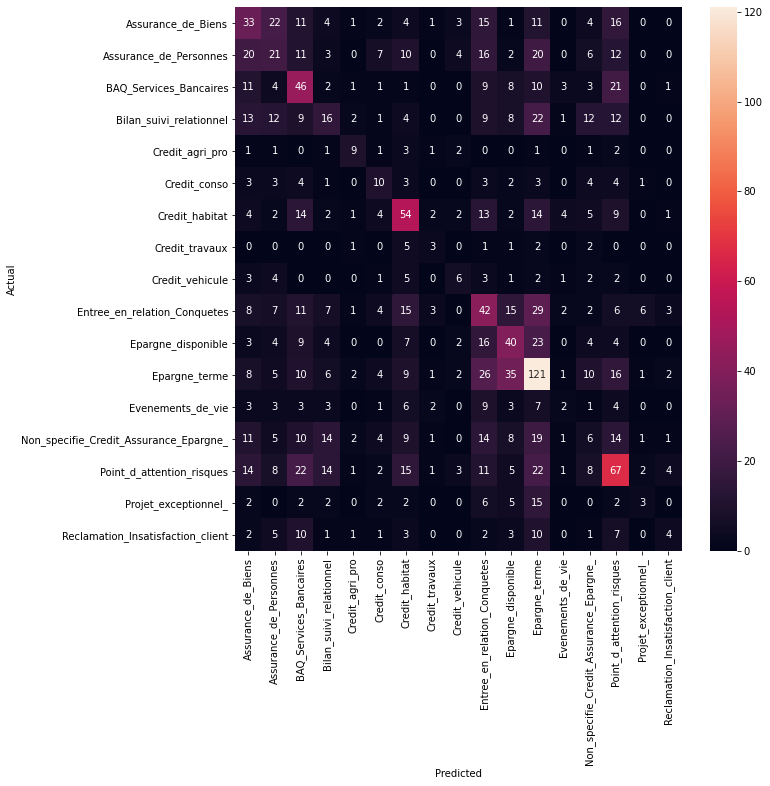

In [127]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.category.values, yticklabels=category_id_df.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## tableau des métrics

In [128]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['category'].unique()))

                                        precision    recall  f1-score   support

                    Assurance_de_Biens       0.24      0.26      0.25       128
                Assurance_de_Personnes       0.20      0.16      0.18       132
                BAQ_Services_Bancaires       0.27      0.38      0.31       121
               Bilan_suivi_relationnel       0.20      0.13      0.16       121
                       Credit_agri_pro       0.41      0.39      0.40        23
                          Credit_conso       0.22      0.24      0.23        41
                        Credit_habitat       0.35      0.41      0.38       133
                        Credit_travaux       0.20      0.20      0.20        15
                       Credit_vehicule       0.25      0.20      0.22        30
          Entree_en_relation_Conquetes       0.22      0.26      0.24       161
                    Epargne_disponible       0.29      0.34      0.31       116
                         Epargne_terme 

## affichage des erreurs

In [175]:
from IPython.display import display

for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 5:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
            display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['category', 'text']])
    print('')

'Assurance_de_Personnes' predicted as 'Assurance_de_Biens' : 20 examples.


,category,text
660,Assurance_de_Personnes,"Suite a appel de courtoisie, Mle travail avec ..."
539,Assurance_de_Personnes,"Dépose contrat , ne souhaite pas PJ pour le mo..."
444,Assurance_de_Personnes,envoi docs pour ouverture vers l avenir Elya...
535,Assurance_de_Personnes,Marie sous la séparation avec 2 enfants à cha...
661,Assurance_de_Personnes,"Suite a appel de courtoisie, Mle travail avec ..."
731,Assurance_de_Personnes,vu pour entretien réaménagement prêt: mais 3em...
559,Assurance_de_Personnes,"Appel téléphonique sortant à ce jour, proposit..."
735,Assurance_de_Personnes,monsieur Pastor vu le 22 janvier par rapport a...
666,Assurance_de_Personnes,Bilan fait avec Mme. \r\nLe couple a un 3008 c...
572,Assurance_de_Personnes,rendez-vous téléphonique ce jour où mademoise...


'BAQ_Services_Bancaires' predicted as 'Assurance_de_Biens' : 11 examples.


,category,text
862,BAQ_Services_Bancaires,Architecte auto-entrepreneur. Célibataire. Loc...
854,BAQ_Services_Bancaires,le client pars en voyage prochainement applic...
861,BAQ_Services_Bancaires,Architecte auto-entrepreneur. Célibataire. Loc...
918,BAQ_Services_Bancaires,MADAME EST ENSEIGNANTE / ACTUELLEMENT EN MISE ...
1116,BAQ_Services_Bancaires,Perçoit une partie de la retraite depuis jan...
976,BAQ_Services_Bancaires,transformation du compte joint en compte indi...
831,BAQ_Services_Bancaires,Entretien avec Monsieur et Madame:\r\n- 1 mo...
844,BAQ_Services_Bancaires,Rendez-vous crédit important suite à la vent...
803,BAQ_Services_Bancaires,marie communauté\r\n2 enfants dont son fils qu...
1077,BAQ_Services_Bancaires,mise en place du CAC budget protéger ration d...


'Bilan_suivi_relationnel' predicted as 'Assurance_de_Biens' : 13 examples.


,category,text
1299,Bilan_suivi_relationnel,RDV réalisé ce jour pour bilan IARD (= récupér...
1224,Bilan_suivi_relationnel,Rendez-vous crédit important suite à la vent...
1457,Bilan_suivi_relationnel,bilan téléphonique IARD concernant A4 Monsieu...
1509,Bilan_suivi_relationnel,bilan global assurance propriétaire de sa r...
1246,Bilan_suivi_relationnel,Anciens commerçants supérette Belbex.\r\nMécon...
1461,Bilan_suivi_relationnel,Compte associé :\nGestion bien locatif -> Mens...
1216,Bilan_suivi_relationnel,échange avec le client suite à une demande de...
1386,Bilan_suivi_relationnel,Bilan fait avec Mme. \r\nLe couple a un 3008 c...
1275,Bilan_suivi_relationnel,compte de mme mr à la retraite flux et place...
1240,Bilan_suivi_relationnel,Architecte auto-entrepreneur. Célibataire. Loc...


'Entree_en_relation_Conquetes' predicted as 'Assurance_de_Biens' : 8 examples.


,category,text
2325,Entree_en_relation_Conquetes,marie communauté\r\n2 enfants dont son fils qu...
2421,Entree_en_relation_Conquetes,il a reçu le client ce jour suite à ma demand...
2644,Entree_en_relation_Conquetes,02/20 : en compagnie de son fils unique lauren...
2708,Entree_en_relation_Conquetes,monsieur Pastor vu le 22 janvier par rapport a...
2357,Entree_en_relation_Conquetes,Entretien avec Monsieur et Madame:\r\n- 1 mo...
2355,Entree_en_relation_Conquetes,"J'ai contacté le client le 10 janvier 2020, s..."
2324,Entree_en_relation_Conquetes,marie communauté\r\n2 enfants dont son fils qu...
2358,Entree_en_relation_Conquetes,Entretien avec Monsieur et Madame:\r\n- 1 mo...


'Epargne_terme' predicted as 'Assurance_de_Biens' : 8 examples.


,category,text
3536,Epargne_terme,transformation du compte joint en compte indi...
3535,Epargne_terme,rdv tel ce jour / madame souhaite des conseils...
3171,Epargne_terme,"pour débloquer 2000 € de son vers l'avenir ,n..."
3226,Epargne_terme,Suite rdv dans le but de réaménager son prêt...
3537,Epargne_terme,transformation du compte joint en compte indi...
3822,Epargne_terme,"Souscription à ce jour de part sociale, de la..."
3172,Epargne_terme,Echu Sonance vie 4 sur P9. Mme voulait en prof...
3861,Epargne_terme,donation des parents de Monsieur d'un montant...


'Non_specifie_Credit_Assurance_Epargne_' predicted as 'Assurance_de_Biens' : 11 examples.


,category,text
4330,Non_specifie_Credit_Assurance_Epargne_,monsieur Pastor vu le 22 janvier par rapport a...
4404,Non_specifie_Credit_Assurance_Epargne_,\r\n bilan assurance fait ce jour madame est a...
4183,Non_specifie_Credit_Assurance_Epargne_,RDV réalisé ce jour pour bilan IARD (= récupér...
4067,Non_specifie_Credit_Assurance_Epargne_,nous avons rencontré Madame aujourd'hui. ...
4081,Non_specifie_Credit_Assurance_Epargne_,Entretien avec Monsieur et Madame:\r\n- 1 mo...
4170,Non_specifie_Credit_Assurance_Epargne_,ne plus proposer assurance assurer potassium ...
4068,Non_specifie_Credit_Assurance_Epargne_,vente résidence principale le 24 juillet 1800...
4296,Non_specifie_Credit_Assurance_Epargne_,"Souscription à ce jour de part sociale, de la..."
4152,Non_specifie_Credit_Assurance_Epargne_,client relancer ce jour pour assurer le bien ...
4105,Non_specifie_Credit_Assurance_Epargne_,devis 4x4 \r\n nh maison de sa mère non occupé...


'Point_d_attention_risques' predicted as 'Assurance_de_Biens' : 14 examples.


,category,text
4636,Point_d_attention_risques,compte de mme mr à la retraite flux et place...
4824,Point_d_attention_risques,Bilan fait avec Mme. \r\nLe couple a un 3008 c...
4857,Point_d_attention_risques,mise en place du CAC budget protéger ration d...
4707,Point_d_attention_risques,Mr était content de l'appel mais a refusé la p...
4488,Point_d_attention_risques,la cliente au téléphone car elle souhaite rés...
4448,Point_d_attention_risques,client assuré pour deux roues chez Assu 2000....
4831,Point_d_attention_risques,Proposition refusée par le client. Il souhaite...
4830,Point_d_attention_risques,Proposition refusée par le client. Il souhaite...
4656,Point_d_attention_risques,ne plus proposer assurance assurer potassium ...
4454,Point_d_attention_risques,Echu Sonance vie 4 sur P9. Mme voulait en prof...



'Assurance_de_Biens' predicted as 'Assurance_de_Personnes' : 22 examples.


,category,text
308,Assurance_de_Biens,RDV téléphonique le 15.01.2020 : \r\n\r\n- S...
311,Assurance_de_Biens,Fait devis ass NH + PJ => envoyé par courrier ...
142,Assurance_de_Biens,Somme DAV importante. Pas de projets particuli...
241,Assurance_de_Biens,RDV DU 16/04/2019\nMON PATRIMOINE OK\nRE le 27...
144,Assurance_de_Biens,Somme DAV importante. Pas de projets particuli...
66,Assurance_de_Biens,Depose proposition assurances: NH res Helio ...
4,Assurance_de_Biens,Cliente étudiante en BTS. Fin étude juin 2020....
44,Assurance_de_Biens,propos Gav Vie pro plus garantie décès tran...
137,Assurance_de_Biens,M est chercheur au CNRS en CDD pour 2 ans en g...
378,Assurance_de_Biens,Suite échange du jour souhait épargne livret o...


'Bilan_suivi_relationnel' predicted as 'Assurance_de_Personnes' : 12 examples.


,category,text
1529,Bilan_suivi_relationnel,monsieur est fleuriste \r\n\r\nristourne 24...
1460,Bilan_suivi_relationnel,OUVERTURE LIV A POUR SA FILLE LEANA QUI VIEN...
1328,Bilan_suivi_relationnel,"SUITE BILAN FAIT CE JOUR, SOUS A4-NH-AAV. DEVI..."
1431,Bilan_suivi_relationnel,"Client assuré Groupama, ancien assuré PACIFICA..."
1515,Bilan_suivi_relationnel,Suite échange du jour souhait épargne livret o...
1309,Bilan_suivi_relationnel,vu le 21 janvier 2020 propos reprise prêt c...
1427,Bilan_suivi_relationnel,Fait devis ass NH + PJ => envoyé par courrier ...
1237,Bilan_suivi_relationnel,Eu en rdv ce jour pour un crédit voiture de 97...
1265,Bilan_suivi_relationnel,PROPOSITION GOBS ET ASS VIE + BILAN IARD.
1470,Bilan_suivi_relationnel,on s'est vu deux fois en rendez-vous on a fai...


'Entree_en_relation_Conquetes' predicted as 'Assurance_de_Personnes' : 7 examples.


,category,text
2443,Entree_en_relation_Conquetes,client se renseigne pour s'assurer par l'inter...
2776,Entree_en_relation_Conquetes,"Mme divorcée, ex mari décédé 2017, touche retr..."
2396,Entree_en_relation_Conquetes,Eu en rdv ce jour pour un crédit voiture de 97...
2652,Entree_en_relation_Conquetes,RDV téléphonique le 15.01.2020 : \r\n\r\n- S...
2329,Entree_en_relation_Conquetes,suite à zoo du 15 janvier 2020 la cliente à...
2778,Entree_en_relation_Conquetes,"Mme divorcée, ex mari décédé 2017, touche retr..."
2379,Entree_en_relation_Conquetes,Depose proposition assurances: NH res Helio ...


'Epargne_terme' predicted as 'Assurance_de_Personnes' : 5 examples.


,category,text
3282,Epargne_terme,REMBOURSEMENT FRAIS LE 21/01\r\nRevoir la clie...
3342,Epargne_terme,Cliente licenciée fin 2019 qui a touché une pr...
3845,Epargne_terme,Etudiante en L2 Licence Arts Plastique à Paul ...
3341,Epargne_terme,Cliente licenciée fin 2019 qui a touché une pr...
3567,Epargne_terme,Rdv avec Mme pour PER : ok 2 PER à faire dès q...


'Non_specifie_Credit_Assurance_Epargne_' predicted as 'Assurance_de_Personnes' : 5 examples.


,category,text
4331,Non_specifie_Credit_Assurance_Epargne_,"client ok pour mettre en place abo, bien que..."
4063,Non_specifie_Credit_Assurance_Epargne_,Souhait transfert comptes entrants LDD + clo...
4323,Non_specifie_Credit_Assurance_Epargne_,on s'est vu deux fois en rendez-vous on a fai...
4202,Non_specifie_Credit_Assurance_Epargne_,Cliente à GROUPAMA et Allianz pour ses assuran...
4310,Non_specifie_Credit_Assurance_Epargne_,Etudiante en L2 Licence Arts Plastique à Paul ...


'Point_d_attention_risques' predicted as 'Assurance_de_Personnes' : 8 examples.


,category,text
4792,Point_d_attention_risques,souhaitait renegocier son prêt. Pas de poss...
4772,Point_d_attention_risques,RDV DU 16/04/2019\nMON PATRIMOINE OK\nRE le 27...
4548,Point_d_attention_risques,cliente en séjour en Slovénie pendant jusqu'e...
4766,Point_d_attention_risques,renvoi chèque acs au client reçu par pacifica ...
4948,Point_d_attention_risques,Augmentation abonnement P9 répartition 70/30 1...
4812,Point_d_attention_risques,fais devis mutuelle ce jour actuellement as...
4694,Point_d_attention_risques,Monsieur et Madame sont venus me voir car ils...
4644,Point_d_attention_risques,M. et Mme sont sous mutuelle de groupe jusqu...


'Reclamation_Insatisfaction_client' predicted as 'Assurance_de_Personnes' : 5 examples.


,category,text
5120,Reclamation_Insatisfaction_client,Souhait transfert comptes entrants LDD + clo...
5218,Reclamation_Insatisfaction_client,prise en charge 80 € commission d'invention l...
5217,Reclamation_Insatisfaction_client,prise en charge 80 € commission d'invention l...
5254,Reclamation_Insatisfaction_client,Mr et Mme sont venus en rdv pour résilisation ...
5194,Reclamation_Insatisfaction_client,"Changement de situation (retraite), entre 980-..."



'Assurance_de_Biens' predicted as 'BAQ_Services_Bancaires' : 11 examples.


,category,text
29,Assurance_de_Biens,RDV pris par la cliente suite à la réception d...
265,Assurance_de_Biens,160117=mail pour pret attente justifs revenus...
125,Assurance_de_Biens,Prospect nouveau client CACF prêt concrétisé v...
188,Assurance_de_Biens,Rendez-vous ce jour avec la cliente qui souhai...
117,Assurance_de_Biens,15/06/2020 Point dossier : offre en acceptatio...
170,Assurance_de_Biens,"Bonjour,\r\n\r\nJ'ai fait un prêt immobilier à..."
261,Assurance_de_Biens,Suite à contact atourisk - proposition budget ...
162,Assurance_de_Biens,Entretien pour point sur prelevements et paiem...
294,Assurance_de_Biens,Suite départ de notre collègue A Chassaing rep...
185,Assurance_de_Biens,suite à la mise en place du crédit immobilier ...


'Assurance_de_Personnes' predicted as 'BAQ_Services_Bancaires' : 11 examples.


,category,text
534,Assurance_de_Personnes,Entretien pour point sur prelevements et paiem...
548,Assurance_de_Personnes,"Bonjour,\r\n\r\nJ'ai fait un prêt immobilier à..."
776,Assurance_de_Personnes,-> mécontente suite à fraude cb pas prise en c...
584,Assurance_de_Personnes,Seul Monsieur était présent. Client pas venu à...
649,Assurance_de_Personnes,Suite à contact atourisk - proposition budget ...
538,Assurance_de_Personnes,RDV le 04/03/20 : Ouverture d'un second compte...
775,Assurance_de_Personnes,-> mécontente suite à fraude cb pas prise en c...
695,Assurance_de_Personnes,madame madame Raucoules est passé à l'agence ...
509,Assurance_de_Personnes,Prospect nouveau client CACF prêt concrétisé v...
622,Assurance_de_Personnes,Pas d'augmentation de découvert avec les reven...


'Bilan_suivi_relationnel' predicted as 'BAQ_Services_Bancaires' : 9 examples.


,category,text
1430,Bilan_suivi_relationnel,entretien du 9 octobre 2019 \r\n Point su...
1343,Bilan_suivi_relationnel,suite meilleur situation financière / point su...
1419,Bilan_suivi_relationnel,rendez-vous annuel droit au compte : le clie...
1523,Bilan_suivi_relationnel,envoie formulaire Demande changement de date ...
1367,Bilan_suivi_relationnel,Travaille dans la restauration à l'hôtel sequo...
1484,Bilan_suivi_relationnel,J'ai vu le client aujourd'hui pour l'ouverture...
1259,Bilan_suivi_relationnel,Prospect nouveau client CACF prêt concrétisé v...
1391,Bilan_suivi_relationnel,suite mail client du 25 mars et sa relance té...
1250,Bilan_suivi_relationnel,madame souhaitait faire le point sur ses comp...


'Credit_habitat' predicted as 'BAQ_Services_Bancaires' : 14 examples.


,category,text
2049,Credit_habitat,rendez-vous du 5 octobre 19 pour point sur...
2027,Credit_habitat,Suite départ de notre collègue A Chassaing rep...
2036,Credit_habitat,13/02/2020 : Mme souhaite ouvrir son compte pe...
1902,Credit_habitat,"Bonjour,\r\n\r\nJ'ai fait un prêt immobilier à..."
1997,Credit_habitat,Dossier locatif fait par Romain sur cet intern...
1921,Credit_habitat,suite à la mise en place du crédit immobilier ...
1774,Credit_habitat,Mise en place vu avec la cliente CAC et comm...
2102,Credit_habitat,Facilit n°188162 \r\nFaire commande carte Gold...
2048,Credit_habitat,rendez-vous du 5 octobre 19 pour point sur...
2108,Credit_habitat,j'ai reçu ce matin mademoiselle qui venez...


'Entree_en_relation_Conquetes' predicted as 'BAQ_Services_Bancaires' : 11 examples.


,category,text
2337,Entree_en_relation_Conquetes,crédit immobilier réalisé en convention court...
2315,Entree_en_relation_Conquetes,présentation de l'offre web EDI et Ibis f...
2717,Entree_en_relation_Conquetes,Client installé depuis 1 an demande renégo t...
2338,Entree_en_relation_Conquetes,crédit immobilier réalisé en convention court...
2481,Entree_en_relation_Conquetes,"Bonjour,\r\n\r\nJ'ai fait un prêt immobilier à..."
2716,Entree_en_relation_Conquetes,Client installé depuis 1 an demande renégo t...
2722,Entree_en_relation_Conquetes,J'ai vu le client aujourd'hui pour l'ouverture...
2568,Entree_en_relation_Conquetes,"Vu cliente pour regul compte, signature lettre..."
2645,Entree_en_relation_Conquetes,RDV car ses dépenses courantes ont augmenté ...
2735,Entree_en_relation_Conquetes,rendez-vous de suivi suite à l'édition de l'o...


'Epargne_disponible' predicted as 'BAQ_Services_Bancaires' : 9 examples.


,category,text
2841,Epargne_disponible,Rdv ce jour pour passage 25 ans. \r\nCommande ...
2992,Epargne_disponible,"Vu cliente pour regul compte, signature lettre..."
3098,Epargne_disponible,rendez-vous de suivi suite à l'édition de l'o...
2814,Epargne_disponible,RDV pris par la cliente suite à la réception d...
3045,Epargne_disponible,entretien du 9 octobre 2019 \r\n Point su...
2884,Epargne_disponible,J'ai proposé au client le changement de sa car...
3058,Epargne_disponible,Cliente préférence de Gestion par CA DIRECT ...
3056,Epargne_disponible,Cliente préférence de Gestion par CA DIRECT ...
3129,Epargne_disponible,madame a décidé d'ouvrir un compte chez nous ...


'Epargne_terme' predicted as 'BAQ_Services_Bancaires' : 10 examples.


,category,text
3480,Epargne_terme,"Bonjour,\r\n\r\nJ'ai fait un prêt immobilier à..."
3487,Epargne_terme,Mise en place CAC 3 modules dont 2 premium : f...
3787,Epargne_terme,RDV car ses dépenses courantes ont augmenté ...
3548,Epargne_terme,Seul Monsieur était présent. Client pas venu à...
3870,Epargne_terme,2 pels ont été plafonnés avant les 10 ans et d...
3733,Epargne_terme,pour passage à majorité penser à bien refaire...
3255,Epargne_terme,PEA Madame : vente des actions et et ventilati...
3798,Epargne_terme,rendez-vous du 5 octobre 19 pour point sur...
3197,Epargne_terme,RDV pris par la cliente suite à la réception d...
3500,Epargne_terme,suite à la mise en place du crédit immobilier ...


'Non_specifie_Credit_Assurance_Epargne_' predicted as 'BAQ_Services_Bancaires' : 10 examples.


,category,text
4195,Non_specifie_Credit_Assurance_Epargne_,Seul Monsieur était présent. Client pas venu à...
4412,Non_specifie_Credit_Assurance_Epargne_,Mr et mme ont un compte egalement a la caisse ...
4157,Non_specifie_Credit_Assurance_Epargne_,suite à communication téléphonique du 14 févr...
4184,Non_specifie_Credit_Assurance_Epargne_,Rendez-vous ce jour avec la cliente qui souhai...
4281,Non_specifie_Credit_Assurance_Epargne_,13/02/2020 : Cliente Chef de cabine chez AirFr...
4287,Non_specifie_Credit_Assurance_Epargne_,rendez-vous du 5 octobre 19 pour point sur...
4286,Non_specifie_Credit_Assurance_Epargne_,rendez-vous du 5 octobre 19 pour point sur...
4130,Non_specifie_Credit_Assurance_Epargne_,Mandat de mobilité bancaire pour le compte joi...
4185,Non_specifie_Credit_Assurance_Epargne_,Rendez-vous ce jour avec la cliente qui souhai...
4277,Non_specifie_Credit_Assurance_Epargne_,13/02/2020 : Mme souhaite ouvrir son compte pe...


'Point_d_attention_risques' predicted as 'BAQ_Services_Bancaires' : 22 examples.


,category,text
4966,Point_d_attention_risques,Mail de Mr ce jour qui ne veut plus de sa ca...
4794,Point_d_attention_risques,Travaille dans la restauration à l'hôtel sequo...
4526,Point_d_attention_risques,ouverture d'un compte pro \n souscription ...
4467,Point_d_attention_risques,crédit immobilier réalisé en convention court...
4841,Point_d_attention_risques,03/03/2020 : est au 5ème jour de préavis Mam...
4658,Point_d_attention_risques,"Bonjour,\r\n\r\nJ'ai fait un prêt immobilier à..."
4864,Point_d_attention_risques,13/02/2020 : Mme souhaite ouvrir son compte pe...
4854,Point_d_attention_risques,Suite départ de notre collègue A Chassaing rep...
4852,Point_d_attention_risques,couple en instance de séparation pas de pro...
4836,Point_d_attention_risques,03/03/2020 : est au 5ème jour de préavis Mam...


'Reclamation_Insatisfaction_client' predicted as 'BAQ_Services_Bancaires' : 10 examples.


,category,text
5260,Reclamation_Insatisfaction_client,-> mécontente suite à fraude cb pas prise en c...
5240,Reclamation_Insatisfaction_client,entretien téléphonique le 29 mai avec Monsieur...
5257,Reclamation_Insatisfaction_client,madame a décidé d'ouvrir un compte chez nous ...
5158,Reclamation_Insatisfaction_client,madame souhaitait faire le point sur ses comp...
5199,Reclamation_Insatisfaction_client,le client a envoyé un mail pour obtenir un ges...
5226,Reclamation_Insatisfaction_client,cotisation carte gold moitie prix la 1ere anne...
5258,Reclamation_Insatisfaction_client,madame a décidé d'ouvrir un compte chez nous ...
5154,Reclamation_Insatisfaction_client,retro carte effectué le 16 10 2019
5263,Reclamation_Insatisfaction_client,Mr et mme ont un compte egalement a la caisse ...
5259,Reclamation_Insatisfaction_client,madame a décidé d'ouvrir un compte chez nous ...



'Entree_en_relation_Conquetes' predicted as 'Bilan_suivi_relationnel' : 7 examples.


,category,text
2591,Entree_en_relation_Conquetes,mr et mme souhaite donner à leurs petits enfan...
2527,Entree_en_relation_Conquetes,"Client/tel, bonne relation avec le Crédit Agri..."
2447,Entree_en_relation_Conquetes,rdv du 11102019- arrêt d'activité en cours s...
2629,Entree_en_relation_Conquetes,MLA LE 17/06/2020 'ai restitué la carte banca...
2528,Entree_en_relation_Conquetes,"Client/tel, bonne relation avec le Crédit Agri..."
2682,Entree_en_relation_Conquetes,Mère célibataire avec 2 enfants à charge.\nDev...
2744,Entree_en_relation_Conquetes,BILAN COMPTE. REGULARISTION DU COMPTE PAR 400...


'Epargne_terme' predicted as 'Bilan_suivi_relationnel' : 6 examples.


,category,text
3170,Epargne_terme,POINT SUR EPARGNE / propo 10 ke sur P9 a re...
3447,Epargne_terme,POINT SUR LES COMPTES / VOIR AUGMENTATION OVP ...
3145,Epargne_terme,Message répondeur laissé sur le portable pour ...
3595,Epargne_terme,assurance non : a la maif 03/19 : rdvs pr four...
3833,Epargne_terme,\r\nProposition de souscription de PER pour Mm...
3397,Epargne_terme,rdv du 11102019- arrêt d'activité en cours s...


'Non_specifie_Credit_Assurance_Epargne_' predicted as 'Bilan_suivi_relationnel' : 14 examples.


,category,text
4399,Non_specifie_Credit_Assurance_Epargne_,- mr RMCL = retraite mai 2020\r\n- MME Maroqui...
4268,Non_specifie_Credit_Assurance_Epargne_,Contact tel MR proposition BILAN ASSURANCE: R...
4211,Non_specifie_Credit_Assurance_Epargne_,appelle ce jour remboursement anticipé en d...
4364,Non_specifie_Credit_Assurance_Epargne_,"echange tél avec mr , ok pour convenir d'un rd..."
4366,Non_specifie_Credit_Assurance_Epargne_,rendez-vous pour faire un point annuel sur l'...
4311,Non_specifie_Credit_Assurance_Epargne_,Mère célibataire avec 2 enfants à charge.\nDev...
4254,Non_specifie_Credit_Assurance_Epargne_,Madame est venue pour faire un point sur son...
4092,Non_specifie_Credit_Assurance_Epargne_,on se rappelle pour gobs 4400 euros + lef po...
4275,Non_specifie_Credit_Assurance_Epargne_,j'ai reçu madame aujourd'hui nous avons planif...
4091,Non_specifie_Credit_Assurance_Epargne_,on se rappelle pour gobs 4400 euros + lef po...


'Point_d_attention_risques' predicted as 'Bilan_suivi_relationnel' : 14 examples.


,category,text
4530,Point_d_attention_risques,Madame est sans emploi depuis septembre 2019. ...
4647,Point_d_attention_risques,monsieur a apprécié notre appel de courtoisie...
4898,Point_d_attention_risques,Mère célibataire avec 2 enfants à charge.\nDev...
4890,Point_d_attention_risques,Echange tel concernant la situation. propositi...
4891,Point_d_attention_risques,Echange tel concernant la situation. propositi...
4860,Point_d_attention_risques,j'ai reçu madame aujourd'hui nous avons planif...
4828,Point_d_attention_risques,RDV ce jour avec M.Casse suite recrutement BPD...
4771,Point_d_attention_risques,"-> rdv inutile, pensaient avoir encore les 2 i..."
4645,Point_d_attention_risques,arret de l'activité chomage partiel des salari...
4952,Point_d_attention_risques,rendez-vous pour faire un point annuel sur l'...




'Assurance_de_Personnes' predicted as 'Credit_conso' : 7 examples.


,category,text
487,Assurance_de_Personnes,cliente reçu ce jour pour montage crédit cons...
678,Assurance_de_Personnes,vu le 15 janvier 2020 pour un prêt conso deux ...
533,Assurance_de_Personnes,REMBOURSEMENT PRET CONSO CE JOUR + PROJET NOUV...
567,Assurance_de_Personnes,appel black friday/ pas de projet/ depose pj
716,Assurance_de_Personnes,monsieur à un projet de crédit conso de 2000 ...
519,Assurance_de_Personnes,MADAME CARON VA AVOIR UNE MOBILITE PRO DEBUT J...
576,Assurance_de_Personnes,projet préparation des obsèques avec le fina...



'Assurance_de_Personnes' predicted as 'Credit_habitat' : 10 examples.


,category,text
598,Assurance_de_Personnes,Madame a vendu sa maison A cerilly elle so...
608,Assurance_de_Personnes,Mr est chauffeur poids lourds pour courcelles ...
727,Assurance_de_Personnes,Mr travaille en intérim pour Bouygue -> doit d...
582,Assurance_de_Personnes,Mme air caraibes à temps partiel 50%\r\nMr mut...
556,Assurance_de_Personnes,mademoiselle Esteves travaille à la mairie d'...
728,Assurance_de_Personnes,Mr travaille en intérim pour Bouygue -> doit d...
470,Assurance_de_Personnes,entretien téléphonique avec Monsieur concerna...
471,Assurance_de_Personnes,entretien téléphonique avec Monsieur concerna...
408,Assurance_de_Personnes,cliente cliente reçu le 8 octobre pour renég...
621,Assurance_de_Personnes,appelle car madame est éligible à une offre c...


'Credit_travaux' predicted as 'Credit_habitat' : 5 examples.


,category,text
2188,Credit_travaux,Instruction prêt travaux complémentaire à opér...
2140,Credit_travaux,Rendez-vous avec le client \r\nDifférents proj...
2165,Credit_travaux,rendez-vous pris pour faire connaissance et on...
2152,Credit_travaux,rdv le 22/05/2020 avec mr lecuyer et sa maman....
2177,Credit_travaux,"vda le 24/09/20: tel Mme Ciccone, déménageme..."


'Credit_vehicule' predicted as 'Credit_habitat' : 5 examples.


,category,text
2193,Credit_vehicule,Rendez-vous avec le client \r\nDifférents proj...
2211,Credit_vehicule,entretien téléphonique avec Monsieur concerna...
2266,Credit_vehicule,Client est routier. \r\nFin intérim mi dec 2...
2214,Credit_vehicule,CDI IME MARMANHAC DEPUIS 3 ANS - 2 ENFANTS PEN...
2217,Credit_vehicule,"Mme, locataire sur Moutier Rozeille, en CDI ..."


'Entree_en_relation_Conquetes' predicted as 'Credit_habitat' : 15 examples.


,category,text
2781,Entree_en_relation_Conquetes,"Fait simul habitat terrain+constructuon, 200/2..."
2484,Entree_en_relation_Conquetes,RDV COUPLE CONCUBINAGE PROSPECT AVEC 1 ENFANT ...
2663,Entree_en_relation_Conquetes,demande de financement suite à achat villa a R...
2510,Entree_en_relation_Conquetes,rendez-vous pris pour faire connaissance et on...
2551,Entree_en_relation_Conquetes,Mr et mme son mariés sans contrat de mariage. ...
2552,Entree_en_relation_Conquetes,Mr et mme son mariés sans contrat de mariage. ...
2407,Entree_en_relation_Conquetes,monsieur à un projet d'achat de sa résidence...
2531,Entree_en_relation_Conquetes,M MME MARIES - 5 ENFANTS + 17 PETITS ENFANTS\r...
2784,Entree_en_relation_Conquetes,le client travaille chez Limagrain . Il est ch...
2339,Entree_en_relation_Conquetes,cliente divorcee avec 2 enfants qui vivent ave...


'Epargne_disponible' predicted as 'Credit_habitat' : 7 examples.


,category,text
3032,Epargne_disponible,Client eu au tel le 30/01/2020 pour me présent...
3126,Epargne_disponible,"27-06-20 David1-Rdv suite asa, optimisation ép..."
3031,Epargne_disponible,Client eu au tel le 30/01/2020 pour me présent...
2895,Epargne_disponible,Mlle vue ce jour pour point épargne Banque Pos...
3127,Epargne_disponible,"27-06-20 David1-Rdv suite asa, optimisation ép..."
2831,Epargne_disponible,M Mme vus ce jour pour validation LEP\r\nVerse...
2832,Epargne_disponible,M Mme vus ce jour pour validation LEP\r\nVerse...


'Epargne_terme' predicted as 'Credit_habitat' : 9 examples.


,category,text
3761,Epargne_terme,rencontre ce jour pour projet immobilier tr...
3760,Epargne_terme,rencontre ce jour pour projet immobilier tr...
3759,Epargne_terme,rencontre ce jour pour projet immobilier tr...
3471,Epargne_terme,projet immobilier évoqué ce jour\r\n activa...
3302,Epargne_terme,madame actuellement en contrat CDI depuis le...
3561,Epargne_terme,le client vend sa résidence secondaire 90000 ...
3169,Epargne_terme,RDV tel pour faire le point sur épargne - fact...
3889,Epargne_terme,MON PATRIMOINE OK\r\nappartement a st pierre l...
3890,Epargne_terme,MON PATRIMOINE OK\r\nappartement a st pierre l...


'Evenements_de_vie' predicted as 'Credit_habitat' : 6 examples.


,category,text
3975,Evenements_de_vie,Va signer la vente de sa RP pour 290K€ le 2/01...
3949,Evenements_de_vie,point sur la situation patrimoniale et fis...
4026,Evenements_de_vie,SS° de sa maman \nPartage en cours \n\nVente d...
3972,Evenements_de_vie,cliente comédienne intermittente du spectacle ...
4029,Evenements_de_vie,Je viens d'avoir madame au téléphone concernan...
3964,Evenements_de_vie,le client vend sa résidence secondaire 90000 ...


'Non_specifie_Credit_Assurance_Epargne_' predicted as 'Credit_habitat' : 9 examples.


,category,text
4327,Non_specifie_Credit_Assurance_Epargne_,PRESENTATION + LE POINT PRET HAB DEBLOCAGE ASS...
4149,Non_specifie_Credit_Assurance_Epargne_,cliente pacse - 2 enfants- multibancarisee- mr...
4192,Non_specifie_Credit_Assurance_Epargne_,Demande prêt conso sur 3 ans - 1000€ pour acha...
4321,Non_specifie_Credit_Assurance_Epargne_,Client est routier. \r\nFin intérim mi dec 2...
4217,Non_specifie_Credit_Assurance_Epargne_,appelle car madame est éligible à une offre c...
4173,Non_specifie_Credit_Assurance_Epargne_,RDV COUPLE CONCUBINAGE PROSPECT AVEC 1 ENFANT ...
4322,Non_specifie_Credit_Assurance_Epargne_,Nous avons expliqué à notre client pourquoi ...
4409,Non_specifie_Credit_Assurance_Epargne_,le client travaille chez Limagrain . Il est ch...
4411,Non_specifie_Credit_Assurance_Epargne_,11/01/2020\r\n\r\nRACHAT ANTICIPE DU PRET IMMO...


'Point_d_attention_risques' predicted as 'Credit_habitat' : 15 examples.


,category,text
4769,Point_d_attention_risques,appelle car madame est éligible à une offre c...
4431,Point_d_attention_risques,Monsieur est intermittent du spectacle depuis ...
4756,Point_d_attention_risques,Mr est chauffeur poids lourds pour courcelles ...
4447,Point_d_attention_risques,RDV tel pour faire le point sur épargne - fact...
4664,Point_d_attention_risques,appelle ce jour le 20 mai 2020 pour essayer d...
4430,Point_d_attention_risques,Monsieur est intermittent du spectacle depuis ...
4441,Point_d_attention_risques,du client ce jour pour un réaménagement alors...
4545,Point_d_attention_risques,la cliente vient de déménager dans sa nouvell...
4641,Point_d_attention_risques,clients restent chez leur assureur.
4479,Point_d_attention_risques,M Mme vus ce jour pour validation LEP\r\nVerse...





'Assurance_de_Biens' predicted as 'Entree_en_relation_Conquetes' : 15 examples.


,category,text
42,Assurance_de_Biens,Tél cliente le 02/06/20 : Mme est séparé avec ...
138,Assurance_de_Biens,la cliente est au chômage depuis plus d'un an...
98,Assurance_de_Biens,la cliente voulait faire le point sur son assu...
217,Assurance_de_Biens,Refus assurances. Client satisfait et fidèle à...
159,Assurance_de_Biens,"Projet achat véhicule en Allemagne, Audi A 4 s..."
398,Assurance_de_Biens,Second rendez-vous suite entrée en relation. M...
189,Assurance_de_Biens,Vu avec Madame pour ouverture d'un livret A po...
33,Assurance_de_Biens,Nouvelle client à qui nous avons financé la RP...
124,Assurance_de_Biens,reçu ce jour pour faire un point sur les comp...
253,Assurance_de_Biens,rendez-vous demande pret travaux 20000 € sur ...


'Assurance_de_Personnes' predicted as 'Entree_en_relation_Conquetes' : 16 examples.


,category,text
405,Assurance_de_Personnes,La cliente est en intérim depuis aout 2019. il...
737,Assurance_de_Personnes,Fait partie de la communauté des gens du voyag...
704,Assurance_de_Personnes,"Vient d'emménager dans la région, client au CA..."
552,Assurance_de_Personnes,madame à 2 enfants 44 ans et 46 ans fille...
636,Assurance_de_Personnes,rendez-vous demande pret travaux 20000 € sur ...
481,Assurance_de_Personnes,Mess port Mme pour lui proposer l'offre GAD à ...
639,Assurance_de_Personnes,rendez-vous demande pret travaux 20000 € sur ...
507,Assurance_de_Personnes,eu le 28/02 propo mutuel mais sous la cmcu
771,Assurance_de_Personnes,"Monsieur en possède une avec la mine, Mme l' a..."
581,Assurance_de_Personnes,MR COMPTE A LA CE/ COMPTE JOINT MR ET MME A ...


'BAQ_Services_Bancaires' predicted as 'Entree_en_relation_Conquetes' : 9 examples.


,category,text
799,BAQ_Services_Bancaires,la cliente va refonctionner avec nous elle a f...
965,BAQ_Services_Bancaires,Le client a ouvert son compte afin de domicili...
1122,BAQ_Services_Bancaires,Mr et Mme vus ce jour pour leur fils qui a un ...
962,BAQ_Services_Bancaires,Vu avec Madame pour ouverture d'un livret A po...
871,BAQ_Services_Bancaires,Reco de sa soeur\r\nActuellement en bac L. Sou...
1084,BAQ_Services_Bancaires,ere mineur pour ouverture dav car mle commence...
812,BAQ_Services_Bancaires,Nouvelle client à qui nous avons financé la RP...
1176,BAQ_Services_Bancaires,rendez-vous annuel pour gestion des comptes p...
917,BAQ_Services_Bancaires,MME A EFFECTUE MANDAT MACRON MAIS SOUHAITE CON...


'Bilan_suivi_relationnel' predicted as 'Entree_en_relation_Conquetes' : 9 examples.


,category,text
1433,Bilan_suivi_relationnel,rendez-vous du 9 janvier 2020 : ouverture com...
1471,Bilan_suivi_relationnel,"Mme est coiffeuse en CDI depuis 12 ans, elle e..."
1458,Bilan_suivi_relationnel,la cliente a touché un héritage de sa maman...
1196,Bilan_suivi_relationnel,il y a 2 ans reconversion pro\r\n M AGENCE MAN...
1432,Bilan_suivi_relationnel,rendez-vous du 9 janvier 2020 : ouverture com...
1329,Bilan_suivi_relationnel,reçu MR et Mme ce jour en rdv:\r\n\r\nMr et Mm...
1474,Bilan_suivi_relationnel,Fait partie de la communauté des gens du voyag...
1245,Bilan_suivi_relationnel,la cliente voulait faire le point sur son assu...
1376,Bilan_suivi_relationnel,Mme a souhaité me rencontrer pour faire conna...


'Credit_habitat' predicted as 'Entree_en_relation_Conquetes' : 13 examples.


,category,text
2091,Credit_habitat,MR agent sncf depuis 2001\r\nMme CDI ADMR depu...
1744,Credit_habitat,Couple en séparation. Simul faite sur rachat d...
1912,Credit_habitat,je reçois aujourd'hui monsieur et Madame t'...
1951,Credit_habitat,"Dossier vu avec le 09/08/2019, demande de caut..."
2016,Credit_habitat,Entretien rapide pour savoir s'il pouvait tran...
1922,Credit_habitat,ream ok defensif poste vu sylvie + ouverture l...
1989,Credit_habitat,le client vit en concubinage un enfant pas ...
1771,Credit_habitat,Nouvelle client à qui nous avons financé la RP...
1768,Credit_habitat,projet achat maison mais quand cdi/ mlle est s...
1800,Credit_habitat,"rachat de prêt, \r\nM travaille chez Michelin ..."


'Epargne_disponible' predicted as 'Entree_en_relation_Conquetes' : 16 examples.


,category,text
3118,Epargne_disponible,RDV 20/11/2019: recu avec sa fille cliente BC...
3029,Epargne_disponible,ACHAT RP A AUBIERE\r\nMME EST PROSPECT A FAIRE...
3021,Epargne_disponible,rencontré le 19.05.17. mr est directeur de lyc...
3022,Epargne_disponible,rencontré le 19.05.17. mr est directeur de lyc...
2938,Epargne_disponible,Vu avec Madame pour ouverture d'un livret A po...
2983,Epargne_disponible,"avait un commerce de materiaux construction, m..."
3100,Epargne_disponible,madame me sollicite pour m'occuper des clôture...
3046,Epargne_disponible,"Vient d'emménager dans la région, client au CA..."
2888,Epargne_disponible,DOIT RAMENER IRPP + RECEPISSE DEMANDE CNI CAR ...
2952,Epargne_disponible,Est dans les travaux de sa maison en ce mome...


'Epargne_terme' predicted as 'Entree_en_relation_Conquetes' : 26 examples.


,category,text
3529,Epargne_terme,MR COMPTE A LA CE/ COMPTE JOINT MR ET MME A ...
3553,Epargne_terme,reçu MR et Mme ce jour en rdv:\r\n\r\nMr et Mm...
3659,Epargne_terme,rendez-vous demande pret travaux 20000 € sur ...
3328,Epargne_terme,la cliente voulait faire le point sur son assu...
3379,Epargne_terme,manque pièces justificatives.\r\n volonté d...
3348,Epargne_terme,vu madame ce jour un rendez-vous. Madame vis ...
3353,Epargne_terme,Reco de sa soeur\r\nActuellement en bac L. Sou...
3723,Epargne_terme,rencontré le 19.05.17. mr est directeur de lyc...
3829,Epargne_terme,Mme séparée\n1 fils de 13 ans Andréa en garde ...
3349,Epargne_terme,vu madame ce jour un rendez-vous. Madame vis ...


'Evenements_de_vie' predicted as 'Entree_en_relation_Conquetes' : 9 examples.


,category,text
4032,Evenements_de_vie,Mme va récupérer l'exploitation agricole (vign...
3960,Evenements_de_vie,Décès de Monsieur - eu le fils au téléphone - ...
4014,Evenements_de_vie,Mme séparée\n1 fils de 13 ans Andréa en garde ...
3913,Evenements_de_vie,Déménagement de Amiens vers Bordeaux > suite o...
4024,Evenements_de_vie,Mr est directeur commercial pour une sociét...
4048,Evenements_de_vie,entretien téléphonique monsieur reprend...
3934,Evenements_de_vie,vu madame ce jour un rendez-vous. Madame vis ...
3992,Evenements_de_vie,suite décè de sa maman ouverture compte chèque...
3900,Evenements_de_vie,divorcé + pacsé 2 enfants \r\n3 petits enfants...


'Non_specifie_Credit_Assurance_Epargne_' predicted as 'Entree_en_relation_Conquetes' : 14 examples.


,category,text
4291,Non_specifie_Credit_Assurance_Epargne_,rendez-vous du 9 janvier 2020 : ouverture com...
4361,Non_specifie_Credit_Assurance_Epargne_,Cliente vu le 29/10/19 pour placement épargne ...
4309,Non_specifie_Credit_Assurance_Epargne_,Compte à la Banque populaire pour les opérat...
4150,Non_specifie_Credit_Assurance_Epargne_,la cliente est au chômage depuis plus d'un an...
4086,Non_specifie_Credit_Assurance_Epargne_,reçu client le 3 décembre 2019 avec propositi...
4189,Non_specifie_Credit_Assurance_Epargne_,MR COMPTE A LA CE/ COMPTE JOINT MR ET MME A ...
4205,Non_specifie_Credit_Assurance_Epargne_,Refus assurances. Client satisfait et fidèle à...
4174,Non_specifie_Credit_Assurance_Epargne_,madame à 2 enfants 44 ans et 46 ans fille...
4285,Non_specifie_Credit_Assurance_Epargne_,Mme psichologue enfant en CDI (60%) + 40% auto...
4348,Non_specifie_Credit_Assurance_Epargne_,Entrée en relation pour transfert des comptes ...


'Point_d_attention_risques' predicted as 'Entree_en_relation_Conquetes' : 11 examples.


,category,text
4529,Point_d_attention_risques,client fiché FICP au CIC fin 2023
4947,Point_d_attention_risques,Revenus pour M. et Mme = env. 2 665€ fixe brut...
4700,Point_d_attention_risques,MR COMPTE A LA CE/ COMPTE JOINT MR ET MME A ...
4521,Point_d_attention_risques,rendez-vous téléphonique avec Madame qui n'es...
4520,Point_d_attention_risques,rendez-vous téléphonique avec Madame qui n'es...
4552,Point_d_attention_risques,"SUITE A ENTRETIEN TEL, MLLE ATOEMOESI SOUHAI..."
4535,Point_d_attention_risques,vu madame ce jour un rendez-vous. Madame vis ...
4425,Point_d_attention_risques,il y a 2 ans reconversion pro\r\n M AGENCE MAN...
4483,Point_d_attention_risques,monsieur est venu ouvrir un compte au Crédit ...
4982,Point_d_attention_risques,01/20 : vu Mme qui est éduc à St Nicolas ( la...


'Projet_exceptionnel_' predicted as 'Entree_en_relation_Conquetes' : 6 examples.


,category,text
5101,Projet_exceptionnel_,la cliente a touché un héritage de sa maman...
5009,Projet_exceptionnel_,Le client a reçu de l'argent de procédure de ...
5024,Projet_exceptionnel_,rendez-vous suite décès du père de Monsieur.\...
5090,Projet_exceptionnel_,"Mme, Retraitée Prof des écoles, 82 ans\r\nVeuv..."
5112,Projet_exceptionnel_,Le client nous sollicite ce jour pour un virem...
5047,Projet_exceptionnel_,madame cliente à la Banque Postale. C'est la ...



'BAQ_Services_Bancaires' predicted as 'Epargne_disponible' : 8 examples.


,category,text
1108,BAQ_Services_Bancaires,Ristournes sur frais tenue de compte + CB non ...
896,BAQ_Services_Bancaires,rendez-vous physique car monsieur a reçu un m...
1109,BAQ_Services_Bancaires,Ristournes sur frais tenue de compte + CB non ...
1185,BAQ_Services_Bancaires,"Cliente qui détient un compte courant, un livr..."
1191,BAQ_Services_Bancaires,suite au rendez-vous du 7 novembre 2019 le ...
1161,BAQ_Services_Bancaires,entretien téléphonique effectué ce jour avec ...
1104,BAQ_Services_Bancaires,passage à 25 ans effectué // modification cart...
1163,BAQ_Services_Bancaires,entretien téléphonique effectué ce jour avec ...


'Bilan_suivi_relationnel' predicted as 'Epargne_disponible' : 8 examples.


,category,text
1499,Bilan_suivi_relationnel,reçu MR et Mme ce jour en rdv avec CGP. Poin...
1442,Bilan_suivi_relationnel,Ristournes sur frais tenue de compte + CB non ...
1505,Bilan_suivi_relationnel,entretien téléphonique effectué ce jour avec ...
1490,Bilan_suivi_relationnel,Vue avec sa soeur qui a vendu son restau à St ...
1361,Bilan_suivi_relationnel,Mr et Mme sont venus suite à un courrier d'in...
1220,Bilan_suivi_relationnel,Eu au tel ce jour pour passage à 25 ans:\r\nch...
1513,Bilan_suivi_relationnel,RDV téléphonique pour bilan: \nClients souha...
1439,Bilan_suivi_relationnel,bilan épargne à faire à son retour de vacance...


'Entree_en_relation_Conquetes' predicted as 'Epargne_disponible' : 15 examples.


,category,text
2367,Entree_en_relation_Conquetes,"En cours de divorce, on aurait conseillé à Mr ..."
2306,Entree_en_relation_Conquetes,QUETEL LEA : rdv 05.03.20 suite à succession...
2749,Entree_en_relation_Conquetes,reçu MR et Mme ce jour en rdv avec CGP. Poin...
2378,Entree_en_relation_Conquetes,05/02/2019 : msg tél laissé to\n12/12/18 : Pro...
2340,Entree_en_relation_Conquetes,proposition ce jour de l'ouverture de deux liv...
2374,Entree_en_relation_Conquetes,Eu au tel ce jour pour passage à 25 ans:\r\nch...
2727,Entree_en_relation_Conquetes,"06/05/20 : Livret jeune atteint, propos liv A..."
2748,Entree_en_relation_Conquetes,reçu MR et Mme ce jour en rdv avec CGP. Poin...
2372,Entree_en_relation_Conquetes,REVOIR POUR METTRE EN PLACE DANS UN AN UNE ASS...
2657,Entree_en_relation_Conquetes,"Mail adressé à la fille de Mr :\r\n\r\n""Bonjo..."


'Epargne_terme' predicted as 'Epargne_disponible' : 35 examples.


,category,text
3874,Epargne_terme,versement p9 madame 16700 euros sur uc indic...
3816,Epargne_terme,bilan épargne à faire à son retour de vacance...
3484,Epargne_terme,ce jour virement sur le livret de développeme...
3265,Epargne_terme,05/02/2019 : msg tél laissé to\n12/12/18 : Pro...
3573,Epargne_terme,reçu MR et Mme ce jour en rdv à 4 en présenc...
3677,Epargne_terme,vie de juin à septembre hochet à Valuejols ...
3263,Epargne_terme,rdv téléphonique ce jour avec Mr (MR habite ...
3873,Epargne_terme,versement p9 madame 16700 euros sur uc indic...
3569,Epargne_terme,étude de réaménagement ce jour proposit...
3194,Epargne_terme,proposition versement j'emploie capitaux décè...


'Non_specifie_Credit_Assurance_Epargne_' predicted as 'Epargne_disponible' : 8 examples.


,category,text
4380,Non_specifie_Credit_Assurance_Epargne_,entretien téléphonique effectué ce jour avec ...
4381,Non_specifie_Credit_Assurance_Epargne_,entretien téléphonique effectué ce jour avec ...
4213,Non_specifie_Credit_Assurance_Epargne_,bilan : projection apres rdv \r\ncel monsieu...
4164,Non_specifie_Credit_Assurance_Epargne_,assurances chez groupama - faire le point\nC...
4096,Non_specifie_Credit_Assurance_Epargne_,appel téléphoniques cliente qui a reçu l'accus...
4230,Non_specifie_Credit_Assurance_Epargne_,Mr et Mme sont venus suite à un courrier d'in...
4391,Non_specifie_Credit_Assurance_Epargne_,RDV téléphonique pour bilan: \nClients souha...
4372,Non_specifie_Credit_Assurance_Epargne_,rendez-vous placement disponible. Madame a u...


'Point_d_attention_risques' predicted as 'Epargne_disponible' : 5 examples.


,category,text
4944,Point_d_attention_risques,"06/05/20 : Livret jeune atteint, propos liv A..."
4784,Point_d_attention_risques,Mr et Mme sont venus suite à un courrier d'in...
4513,Point_d_attention_risques,* 17 décembre demande du client de virer 7000...
4959,Point_d_attention_risques,entretien téléphonique effectué ce jour avec ...
4486,Point_d_attention_risques,"En cours de divorce, on aurait conseillé à Mr ..."


'Projet_exceptionnel_' predicted as 'Epargne_disponible' : 5 examples.


,category,text
5042,Projet_exceptionnel_,RDV Epargne suite vente bien clermont ferran...
5019,Projet_exceptionnel_,rdv téléphonique ce jour avec Mr (MR habite ...
5043,Projet_exceptionnel_,RDV Epargne suite vente bien clermont ferran...
5025,Projet_exceptionnel_,projet changement de fenêtre en 2020 par eco P...
5091,Projet_exceptionnel_,"Mail adressé à la fille de Mr :\r\n\r\n""Bonjo..."



'Assurance_de_Biens' predicted as 'Epargne_terme' : 11 examples.


,category,text
72,Assurance_de_Biens,Rdv téléphonique le 28/10/19 : \r\n1. Possède ...
352,Assurance_de_Biens,LE 28/01 BILAN IARD : \r\n\r\n3 NH\r\n2 aut...
30,Assurance_de_Biens,Mr travaille chez Disney. Epargne à 99% sur ...
302,Assurance_de_Biens,mise en place prêt conso ce jour prochain ren...
49,Assurance_de_Biens,"Domiciliée à Aurillac St Eloi, insatisfaite de..."
31,Assurance_de_Biens,Mr travaille chez Disney. Epargne à 99% sur ...
130,Assurance_de_Biens,02/18 : gob proposée à mme mais monsieur est t...
245,Assurance_de_Biens,vu vu un rendez-vous le 4 10 2019 pour trajec...
220,Assurance_de_Biens,Madame souhaitait cloturer son PEL puisqu'elle...
70,Assurance_de_Biens,Rdv téléphonique le 28/10/19 : \r\n1. Possède ...


'Assurance_de_Personnes' predicted as 'Epargne_terme' : 20 examples.


,category,text
489,Assurance_de_Personnes,clients reçus pour un point compte car d'après...
451,Assurance_de_Personnes,FIN DE DROITS POUR LE LEP \r\nPROPOSITION DE ...
452,Assurance_de_Personnes,FIN DE DROITS POUR LE LEP \r\nPROPOSITION DE ...
690,Assurance_de_Personnes,"Mademoiselle , Monsieur \n\nSuite à notre éc..."
541,Assurance_de_Personnes,rendez-vous épargne en ce jour car monsieur a...
428,Assurance_de_Personnes,16/06/20: mail client: souahit clôture AV pour...
675,Assurance_de_Personnes,rendez-vous suite à la vente d'un bien le c...
543,Assurance_de_Personnes,rendez-vous épargne en ce jour car monsieur a...
578,Assurance_de_Personnes,fonctionnement PEA / souhaite acheter des act...
500,Assurance_de_Personnes,OK pour MCD (fonctionnement compte OK : 0j déb...


'BAQ_Services_Bancaires' predicted as 'Epargne_terme' : 10 examples.


,category,text
829,BAQ_Services_Bancaires,"rendez-vous téléphonique de ce jour, transfor..."
1013,BAQ_Services_Bancaires,vu vu un rendez-vous le 4 10 2019 pour trajec...
843,BAQ_Services_Bancaires,la cliente est au pôle emploi et perçoit 900 e...
882,BAQ_Services_Bancaires,OK pour MCD (fonctionnement compte OK : 0j déb...
1014,BAQ_Services_Bancaires,vu vu un rendez-vous le 4 10 2019 pour trajec...
1012,BAQ_Services_Bancaires,vu vu un rendez-vous le 4 10 2019 pour trajec...
849,BAQ_Services_Bancaires,16/05/19 : Proposition DAT Taux boosté.\n09/02...
996,BAQ_Services_Bancaires,vu madame pour rendez-vous succession suite ...
1068,BAQ_Services_Bancaires,"\r\n\r\nBonjour,\r\n\r\nVous avez une caution ..."
1009,BAQ_Services_Bancaires,"Suite acquisition rp, cliente va bientôt clotu..."


'Bilan_suivi_relationnel' predicted as 'Epargne_terme' : 22 examples.


,category,text
1418,Bilan_suivi_relationnel,BE téléphonique le 14.01.20\r\n\r\n3 enfants (...
1398,Bilan_suivi_relationnel,Explication code civil + code des assurances. ...
1414,Bilan_suivi_relationnel,souscription ce jour de 1000 € de parts social...
1290,Bilan_suivi_relationnel,proposition de diversification sur l'assurance...
1363,Bilan_suivi_relationnel,la cliente a eu rendez-vous ce jour dans le bu...
1379,Bilan_suivi_relationnel,Rdv pour connaissance et point global suite re...
1478,Bilan_suivi_relationnel,LE 28/01 BILAN IARD : \r\n\r\n3 NH\r\n2 aut...
1285,Bilan_suivi_relationnel,2ème rencontre - son mari n'a pas pu venir à n...
1393,Bilan_suivi_relationnel,rendez-vous du 8 janvier 2020 monsieur retr...
1326,Bilan_suivi_relationnel,appel le 12 mai 2020 par aso crédit import...


'Credit_habitat' predicted as 'Epargne_terme' : 14 examples.


,category,text
1958,Credit_habitat,Monsieur et Madame sont mariés ils ont un p...
2026,Credit_habitat,Infos détaillées sur supports assurance vie. E...
1931,Credit_habitat,Mr : Pilote de l air \r\nMme: au foyer\r\n2 en...
1852,Credit_habitat,OK pour MCD (fonctionnement compte OK : 0j déb...
1864,Credit_habitat,Ils ont un contrat assurance vie à la concurre...
1755,Credit_habitat,client recommandé.\r\n Travaille en apprentis...
1761,Credit_habitat,Cliente avec abonnement sur predige de 1 500 ...
1933,Credit_habitat,Mr : Pilote de l air \r\nMme: au foyer\r\n2 en...
1754,Credit_habitat,envoie demande de négociation à Éric et Benja...
1784,Credit_habitat,16/06/20: mail client: souahit clôture AV pour...


'Entree_en_relation_Conquetes' predicted as 'Epargne_terme' : 29 examples.


,category,text
2542,Entree_en_relation_Conquetes,monsieur vend sa maison 170000 € il donne 2...
2439,Entree_en_relation_Conquetes,02/18 : gob proposée à mme mais monsieur est t...
2571,Entree_en_relation_Conquetes,La cliente a des soucis de sérieux (prise en c...
2635,Entree_en_relation_Conquetes,BE téléphonique le 14.01.20\r\n\r\n3 enfants (...
2714,Entree_en_relation_Conquetes,le client a reçu 50000 € suite à une successi...
2686,Entree_en_relation_Conquetes,Cliente aura prochainement des travaux à pay...
2586,Entree_en_relation_Conquetes,Monsieur est actuellement en statut de micro...
2636,Entree_en_relation_Conquetes,BE téléphonique le 14.01.20\r\n\r\n3 enfants (...
2709,Entree_en_relation_Conquetes,rendez-vous pour Floriane / fond sonance é...
2661,Entree_en_relation_Conquetes,Point avec ce client qui avait reçu 40 K€ envi...


'Epargne_disponible' predicted as 'Epargne_terme' : 23 examples.


,category,text
2809,Epargne_disponible,Valid Lep + client mécontent rému épargne. P...
3019,Epargne_disponible,les clients suite à l'arrivée à échéance de l...
3036,Epargne_disponible,"Mademoiselle , Monsieur \n\nSuite à notre éc..."
2925,Epargne_disponible,03.06.2020 - Madame a touché 50ke de soulte s...
2990,Epargne_disponible,vu vu un rendez-vous le 4 10 2019 pour trajec...
2961,Epargne_disponible,1 FILS EMPLOYE CHEZ LCL REBOND DIVERSIFICATION...
3067,Epargne_disponible,3 mois a paris et le reste du temps a la vedre...
2942,Epargne_disponible,point ass vie questions cliente sur diversifi...
2793,Epargne_disponible,rendez-vous pour connaissance / mariée 3 enf...
3034,Epargne_disponible,Client demande dénouement de ses 2 ctts ep ret...


'Evenements_de_vie' predicted as 'Epargne_terme' : 7 examples.


,category,text
4001,Evenements_de_vie,BE téléphonique le 14.01.20\r\n\r\n3 enfants (...
3903,Evenements_de_vie,monsieur vient d'être en retraite au mois de ...
3985,Evenements_de_vie,monsieur va payer 71000 € en juillet 2021 d'i...
3897,Evenements_de_vie,client recommandé.\r\n Travaille en apprentis...
4019,Evenements_de_vie,Cliente aura prochainement des travaux à pay...
3930,Evenements_de_vie,"donation enfants 100 000 euros, assurance vi..."
3986,Evenements_de_vie,les clients se sont mariés en octobre 1966 (l...


'Non_specifie_Credit_Assurance_Epargne_' predicted as 'Epargne_terme' : 19 examples.


,category,text
4107,Non_specifie_Credit_Assurance_Epargne_,10012020 conformite- ouverture pel- monsieur ...
4137,Non_specifie_Credit_Assurance_Epargne_,Ils ont un contrat assurance vie à la concurre...
4273,Non_specifie_Credit_Assurance_Epargne_,souscription ce jour de 1000 € de parts social...
4134,Non_specifie_Credit_Assurance_Epargne_,\r\n proposition d'un fond structurer en ...
4110,Non_specifie_Credit_Assurance_Epargne_,VENTE GARAGE EN COURS \nPOUR 20 000 € COMPRO...
4117,Non_specifie_Credit_Assurance_Epargne_,MME a ouvert son institut de beaute il y a 7...
4160,Non_specifie_Credit_Assurance_Epargne_,Salut Bonjour rendez-vous d'aujourd'hui Bill a...
4159,Non_specifie_Credit_Assurance_Epargne_,2ème rencontre - son mari n'a pas pu venir à n...
4371,Non_specifie_Credit_Assurance_Epargne_,REASSURANCE DE LA CLIENTE SUR PER / ET ENSEMBL...
4283,Non_specifie_Credit_Assurance_Epargne_,A VOIR POUR DEBUT ANNEE POUR PLACEMENT ENVIRON...


'Point_d_attention_risques' predicted as 'Epargne_terme' : 22 examples.


,category,text
4747,Point_d_attention_risques,Madame souhaitait cloturer son PEL puisqu'elle...
4583,Point_d_attention_risques,02/18 : gob proposée à mme mais monsieur est t...
4926,Point_d_attention_risques,ANESTHESISTE AU CHU DE NIME CAREMEAU PAS DE ...
4466,Point_d_attention_risques,16/06/20: mail client: souahit clôture AV pour...
4606,Point_d_attention_risques,M veut acheter sa rp <500k€ voire 700k€ villa ...
4582,Point_d_attention_risques,02/18 : gob proposée à mme mais monsieur est t...
4588,Point_d_attention_risques,vu ce jour Monsieur avec ses enfants suite a...
4477,Point_d_attention_risques,10/05/19 : Projet aménagement en Afrique du Su...
4775,Point_d_attention_risques,08/06/18 : RDV présentation.\r\nCloturons CARR...
4793,Point_d_attention_risques,la cliente est venu se renseigner sur notre c...


'Projet_exceptionnel_' predicted as 'Epargne_terme' : 15 examples.


,category,text
5040,Projet_exceptionnel_,Reçue Mme le 05/12/2019 à Chénérailles avec so...
5061,Projet_exceptionnel_,rendez-vous à l'agence ce jour.. Sur l'épargne...
5094,Projet_exceptionnel_,Suite succession oncle : \r\n\r\n- 331ke sur l...
5046,Projet_exceptionnel_,cliente venue ce jour avec son gendre .\r\n ...
5106,Projet_exceptionnel_,le client a reçu 50000 € suite à une successi...
5051,Projet_exceptionnel_,madame dois recevoir un héritage d'ici 3 sema...
5102,Projet_exceptionnel_,3 mois a paris et le reste du temps a la vedre...
5057,Projet_exceptionnel_,Entretien téléphonique le 17 juin 2020 ASO cré...
5081,Projet_exceptionnel_,"prenfre rdv avec gillrs , our point sur succes..."
5062,Projet_exceptionnel_,rendez-vous à l'agence ce jour.. Sur l'épargne...


'Reclamation_Insatisfaction_client' predicted as 'Epargne_terme' : 10 examples.


,category,text
5135,Reclamation_Insatisfaction_client,"Domiciliée à Aurillac St Eloi, insatisfaite de..."
5131,Reclamation_Insatisfaction_client,Factures travaux à financer pour 50k€\r\nRetra...
5201,Reclamation_Insatisfaction_client,rdv à l'agence de BETHISY avec sandrine pour c...
5123,Reclamation_Insatisfaction_client,client recommandé.\r\n Travaille en apprentis...
5225,Reclamation_Insatisfaction_client,3 mois a paris et le reste du temps a la vedre...
5128,Reclamation_Insatisfaction_client,Valid Lep + client mécontent rému épargne. P...
5220,Reclamation_Insatisfaction_client,"RDv client 14/01, mandat à souscrire sur assur..."
5126,Reclamation_Insatisfaction_client,premier rendez-vous de découverte le 9 novemb...
5198,Reclamation_Insatisfaction_client,la cliente a eu rendez-vous ce jour dans le bu...
5219,Reclamation_Insatisfaction_client,11/2019 = se revoir en 2020 pour mise en place...




'Assurance_de_Personnes' predicted as 'Non_specifie_Credit_Assurance_Epargne_' : 6 examples.


,category,text
601,Assurance_de_Personnes,A la retraite depuis novembre. Mr est en insta...
502,Assurance_de_Personnes,j'ai reçu la cliente afin de diversifier les ...
464,Assurance_de_Personnes,Mme est venu pour un bilan épargne. Son livre...
453,Assurance_de_Personnes,deux propos mutuelles integrale et initiale so...
668,Assurance_de_Personnes,message tel client ce jour pour rdv (assurance...
465,Assurance_de_Personnes,Mme est venu pour un bilan épargne. Son livre...


'Bilan_suivi_relationnel' predicted as 'Non_specifie_Credit_Assurance_Epargne_' : 12 examples.


,category,text
1362,Bilan_suivi_relationnel,monsieur a rappelé suite message laissés ASO h...
1223,Bilan_suivi_relationnel,deux propos mutuelles integrale et initiale so...
1203,Bilan_suivi_relationnel,rencontrer Monsieur le 14 janvier proposition ...
1489,Bilan_suivi_relationnel,"eu cliente au tel suite mail, maman d une peti..."
1336,Bilan_suivi_relationnel,projet travaux RP d'environ 20000 € mois OCT ...
1482,Bilan_suivi_relationnel,Mr est journaliste RMB (notamment) essaie de...
1298,Bilan_suivi_relationnel,Contact client suite FMC.\nSolde tout compte s...
1389,Bilan_suivi_relationnel,Proposition RDV pour Bilan assurance - ne veux...
1274,Bilan_suivi_relationnel,Nouveau message laissé sur portable car client...
1319,Bilan_suivi_relationnel,MR a 3 contrats d'assurance à la concurrence A...


'Credit_habitat' predicted as 'Non_specifie_Credit_Assurance_Epargne_' : 5 examples.


,category,text
2104,Credit_habitat,Dossier après réception de l'ensemble des élém...
1819,Credit_habitat,Mme est venu pour un bilan épargne. Son livre...
2118,Credit_habitat,rendez-vous et à notre initiative car le PEL ...
2106,Credit_habitat,A revoir en mai car monsieur doit toucher ...
1790,Credit_habitat,Appel de Monsieur Rivelois le 6 mars suite ve...


'Epargne_terme' predicted as 'Non_specifie_Credit_Assurance_Epargne_' : 10 examples.


,category,text
3668,Epargne_terme,"SUITE A PRET REALISE CHEZ NOUS, POINT SUR PL..."
3703,Epargne_terme,Proposition RDV pour Bilan assurance - ne veux...
3580,Epargne_terme,A la retraite depuis novembre. Mr est en insta...
3669,Epargne_terme,"SUITE A PRET REALISE CHEZ NOUS, POINT SUR PL..."
3150,Epargne_terme,"Mme veuve depuis 04/2019, revu clause bénéfici..."
3156,Epargne_terme,rencontrer Monsieur le 14 janvier proposition ...
3683,Epargne_terme,Mme tenait un routier au pont d' Allier. monsi...
3321,Epargne_terme,suite entretien un pro une opinion
3158,Epargne_terme,rencontrer Monsieur le 14 janvier proposition ...
3566,Epargne_terme,projet travaux RP d'environ 20000 € mois OCT ...


'Point_d_attention_risques' predicted as 'Non_specifie_Credit_Assurance_Epargne_' : 8 examples.


,category,text
4689,Point_d_attention_risques,le client avait une épargne arrivé à terme il...
4806,Point_d_attention_risques,Mme tenait un routier au pont d' Allier. monsi...
4637,Point_d_attention_risques,vu avec Éric Durand mise en place de prêt g...
4782,Point_d_attention_risques,Vu à l'accueil suite ATD avec les impôts en co...
4741,Point_d_attention_risques,projet travaux RP d'environ 20000 € mois OCT ...
4786,Point_d_attention_risques,entreprise multibancarisée\r\n\r\ndemande des ...
4936,Point_d_attention_risques,Relance ce jour concernant l'installation de M...
4428,Point_d_attention_risques,"Mme veuve depuis 04/2019, revu clause bénéfici..."



'Assurance_de_Biens' predicted as 'Point_d_attention_risques' : 16 examples.


,category,text
379,Assurance_de_Biens,En arrêt maladie jusqu'au 15/02/20 (voir prolo...
148,Assurance_de_Biens,Monsieur fait la demande d'une souscription...
113,Assurance_de_Biens,Préparation du rdv tél non honoré :\n- sortie ...
381,Assurance_de_Biens,En arrêt maladie jusqu'au 15/02/20 (voir prolo...
304,Assurance_de_Biens,refus devis
376,Assurance_de_Biens,la cliente souhaite rencontrer un conseiller...
202,Assurance_de_Biens,"2 chèques impayés de 2018 de 387,56e chacun. Q..."
333,Assurance_de_Biens,Monsieur travail actuellement en surveillant ...
380,Assurance_de_Biens,En arrêt maladie jusqu'au 15/02/20 (voir prolo...
192,Assurance_de_Biens,rendez-vous pris à l'initiative de Madame pou...


'Assurance_de_Personnes' predicted as 'Point_d_attention_risques' : 12 examples.


,category,text
683,Assurance_de_Personnes,traitement motif de contact du 12 mars 2020 ...
684,Assurance_de_Personnes,traitement motif de contact du 12 mars 2020 ...
773,Assurance_de_Personnes,a souhaite virer 170ke vers CE sete multibanc...
499,Assurance_de_Personnes,Préparation du rdv tél non honoré :\n- sortie ...
491,Assurance_de_Personnes,"Modif sur carte sociétaire Gold, client voul..."
635,Assurance_de_Personnes,eu le 28/02 propo mutuel mais refus car 10 e...
651,Assurance_de_Personnes,"Le client a souscrit sa mutuelle CRCAM, nous n..."
520,Assurance_de_Personnes,Envoi fiches refus ADE à Laure Compigne
613,Assurance_de_Personnes,cliente d'accord pour passer en CAC budget pr...
435,Assurance_de_Personnes,proposition S5 client pas intéressé mutuelle ...


'BAQ_Services_Bancaires' predicted as 'Point_d_attention_risques' : 21 examples.


,category,text
1022,BAQ_Services_Bancaires,"MV pour demander à faire le point, au vue du c..."
1051,BAQ_Services_Bancaires,RDV ce jour pour point comptes + motif de cont...
1177,BAQ_Services_Bancaires,entretien téléphonique entrant : monsieur ne...
806,BAQ_Services_Bancaires,Il s'agit d'avoirs de Netflix et non de rbsts ...
1172,BAQ_Services_Bancaires,RDV pour versement sur contrat P9 d'Alex. \r\n...
863,BAQ_Services_Bancaires,EU monsieur au téléphone le 13 11 2019 découv...
942,BAQ_Services_Bancaires,le client a-t-il le 30 octobre afin de dema...
873,BAQ_Services_Bancaires,"Modif sur carte sociétaire Gold, client voul..."
1141,BAQ_Services_Bancaires,QUETEL léa: eu le 21.01.2020 suite à débit d...
979,BAQ_Services_Bancaires,"2 chèques impayés de 2018 de 387,56e chacun. Q..."


'Bilan_suivi_relationnel' predicted as 'Point_d_attention_risques' : 12 examples.


,category,text
1520,Bilan_suivi_relationnel,entretien téléphonique entrant : monsieur ne...
1262,Bilan_suivi_relationnel,Madame est surendettée. \r\nAugmentation du dé...
1272,Bilan_suivi_relationnel,Com tel avec sa soeur qui a procuration pour f...
1248,Bilan_suivi_relationnel,Partie PRO :\r\nClient a eu quelques jours de ...
1332,Bilan_suivi_relationnel,client qui à ce jour ne souhaite pas changer ...
1234,Bilan_suivi_relationnel,Cliente ayant demandé un rendez-vous pour fair...
1270,Bilan_suivi_relationnel,la cliente a pris rendez-vous pour faire le p...
1491,Bilan_suivi_relationnel,"Transporteur, pas impacté pour le moment"
1261,Bilan_suivi_relationnel,Madame est surendettée. \r\nAugmentation du dé...
1197,Bilan_suivi_relationnel,la cliente est injoignable au numéro figurant...


'Credit_habitat' predicted as 'Point_d_attention_risques' : 9 examples.


,category,text
2070,Credit_habitat,Le client est revenu nous voir pour projet i...
1961,Credit_habitat,suite à un coup de téléphone reçu de Monsieur...
1919,Credit_habitat,monsieur et client LCL car à financer sa r...
2071,Credit_habitat,Le client est revenu nous voir pour projet i...
1916,Credit_habitat,"Suite séparation, vente du bien en cours (sign..."
1853,Credit_habitat,Mr est SQPR... son contrat se finit dans 6 moi...
1949,Credit_habitat,"2 chèques impayés de 2018 de 387,56e chacun. Q..."
1977,Credit_habitat,Client se présente aujourd'hui car il achète s...
2069,Credit_habitat,Le client est revenu nous voir pour projet i...


'Entree_en_relation_Conquetes' predicted as 'Point_d_attention_risques' : 6 examples.


,category,text
2460,Entree_en_relation_Conquetes,la cliente a 700 euros pour vivre sur le mois...
2493,Entree_en_relation_Conquetes,Mme en conté parental. Doit reprendre le trava...
2764,Entree_en_relation_Conquetes,En arrêt maladie jusqu'au 15/02/20 (voir prolo...
2381,Entree_en_relation_Conquetes,Recommandé par Mr \nEn France depuis avril 202...
2478,Entree_en_relation_Conquetes,Mise en place découvert passager sur compte ...
2736,Entree_en_relation_Conquetes,27/11/19: point PERP + info PER\r\nOn reste su...


'Epargne_terme' predicted as 'Point_d_attention_risques' : 16 examples.


,category,text
3523,Epargne_terme,Dénouement du Plan Vert Vitalité de Madame dem...
3770,Epargne_terme,traitement motif de contact du 12 mars 2020 ...
3412,Epargne_terme,proposition de versement sur son assurance vi...
3276,Epargne_terme,part sociale envoyées à COF/MA ce jour pour p...
3368,Epargne_terme,monsieur associé du Père-Fils) - prélèveme...
3210,Epargne_terme,pas intéressé par les parts sociales pour l'i...
3872,Epargne_terme,Alex - la cliente est a la macif et ne veut ...
3411,Epargne_terme,proposition de versement sur son assurance vi...
3814,Epargne_terme,madame détient un contrat obsèques dans un ...
3657,Epargne_terme,et très pris par la construction finalement...


'Non_specifie_Credit_Assurance_Epargne_' predicted as 'Point_d_attention_risques' : 14 examples.


,category,text
4271,Non_specifie_Credit_Assurance_Epargne_,Le taux du dernier crédit n'a pas été bas. I...
4351,Non_specifie_Credit_Assurance_Epargne_,cliente envisage demenagement pour plus gran...
4406,Non_specifie_Credit_Assurance_Epargne_,\r\n proposition du budget protégé. monsieur r...
4397,Non_specifie_Credit_Assurance_Epargne_,entretien téléphonique entrant : monsieur ne...
4200,Non_specifie_Credit_Assurance_Epargne_,client qui à ce jour ne souhaite pas changer ...
4140,Non_specifie_Credit_Assurance_Epargne_,mise à jour ok\r\n\r\nA prévoir rdv ass car ...
4324,Non_specifie_Credit_Assurance_Epargne_,Alex - la cliente est a la macif et ne veut ...
4144,Non_specifie_Credit_Assurance_Epargne_,eu la cliente ce jour au téléphone ne veut pa...
4374,Non_specifie_Credit_Assurance_Epargne_,DAV et Livret A à la Poste : la cliente s'occu...
4139,Non_specifie_Credit_Assurance_Epargne_,Madame est surendettée. \r\nAugmentation du dé...


'Reclamation_Insatisfaction_client' predicted as 'Point_d_attention_risques' : 7 examples.


,category,text
5157,Reclamation_Insatisfaction_client,reçu aujourd'hui de recommandé pour Monsieur ...
5160,Reclamation_Insatisfaction_client,Préparation du rdv tél non honoré :\n- sortie ...
5246,Reclamation_Insatisfaction_client,DAV et Livret A à la Poste : la cliente s'occu...
5247,Reclamation_Insatisfaction_client,clôture du PEL faite le 4 novembre suite à la...
5224,Reclamation_Insatisfaction_client,Monsieur travail actuellement en surveillant ...
5149,Reclamation_Insatisfaction_client,Suite à mails échangés sur la tarification e...
5164,Reclamation_Insatisfaction_client,voir àtourisk



'Entree_en_relation_Conquetes' predicted as 'Projet_exceptionnel_' : 6 examples.


,category,text
2592,Entree_en_relation_Conquetes,Le client a vendu les murs de l'hotel ACOTEL. ...
2457,Entree_en_relation_Conquetes,c'est sûr transmission patrimonial avec des e...
2368,Entree_en_relation_Conquetes,"03.03.20= mr vit seul, proprio RP + terrains, ..."
2490,Entree_en_relation_Conquetes,Compte principale à la Banque Populaire. Clie...
2369,Entree_en_relation_Conquetes,"03.03.20= mr vit seul, proprio RP + terrains, ..."
2346,Entree_en_relation_Conquetes,"reçu /\n\nBonjour,\nMon epouse francoise vien..."


# sauvegarde du modèle

In [198]:
from sklearn.linear_model import LogisticRegression
dependent_variable = 'category_id'
x = df[df.columns.difference([dependent_variable])]
y = df[dependent_variable]
lsvc = LinearSVC()

In [199]:
joblib.dump(lsvc, 'modelsvc.pkl')
print("Model dumped!")

Model dumped!


In [200]:
lsvc = joblib.load('modelsvc.pkl')

In [194]:
model_columns = list(x.columns)
joblib.dump(model_columns, 'model_columns.pkl')
print("Models columns dumped!")

Models columns dumped!


In [178]:
joblib.dump(model, 'modelLsvc.pkl')

['modelLsvc.pkl']

In [179]:
lsvc = joblib.load('modelLSVC.pkl')

# TEST RESEAU NEURONO AVEC BERT

In [160]:

import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

In [161]:
possible_labels = df.category.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'Assurance_de_Biens': 0,
 'Assurance_de_Personnes': 1,
 'BAQ_Services_Bancaires': 2,
 'Bilan_suivi_relationnel': 3,
 'Credit_agri_pro': 4,
 'Credit_conso': 5,
 'Credit_habitat': 6,
 'Credit_travaux': 7,
 'Credit_vehicule': 8,
 'Entree_en_relation_Conquetes': 9,
 'Epargne_disponible': 10,
 'Epargne_terme': 11,
 'Evenements_de_vie': 12,
 'Non_specifie_Credit_Assurance_Epargne_': 13,
 'Point_d_attention_risques': 14,
 'Projet_exceptionnel_': 15,
 'Reclamation_Insatisfaction_client': 16}

In [162]:
df['label'] = df.category.replace(label_dict)

In [55]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=df.label.values)

df['text'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

df.groupby(['category', 'label', 'data_type']).count()

text  content  \
category                               label data_type                  
Assurance_de_Biens                     0     train       344      344   
                                             val          61       61   
Assurance_de_Personnes                 1     train       325      325   
                                             val          57       57   
BAQ_Services_Bancaires                 2     train       346      346   
                                             val          61       61   
Bilan_suivi_relationnel                3     train       286      286   
                                             val          51       51   
Credit_agri_pro                        4     train        58       58   
                                             val          10       10   
Credit_conso                           5     train       117      117   
                                             val          21       21   
Credit_habitat                         6     train       341      341   
                                             val          60       60   
Credit_travaux                         7     train        45       45   
                                             val           8        8   
Credit_vehicule                        8     train        81       81   
                                             val          14       14   
Entree_en_relation_Conquetes           9     train       425      425   
                                             val          75       75   
Epargne_disponible                     10    train       301      301   
                                             val          53       53   
Epargne_terme                          11    train       642      642   
                                             val         114      114   
Evenements_de_vie                      12    train       139      139   
                                             val          25       25   
Non_specifie_Credit_Assurance_Epargne_ 13    train       302      302   
                                             val          53       53   
Point_d_attention_risques              14    train       500      500   
                                             val          88       88   
Projet_exceptionnel_                   15    train        97       97   
                                             val          17       17   
Reclamation_Insatisfaction_client      16    train       126      126   
                                             val          22       22   

                                                        category_id  
category                               label data_type               
Assurance_de_Biens                     0     train              344  
                                             val                 61  
Assurance_de_Personnes                 1     train              325  
                                             val                 57  
BAQ_Services_Bancaires                 2     train              346  
                                             val                 61  
Bilan_suivi_relationnel                3     train              286  
                                             val                 51  
Credit_agri_pro                        4     train               58  
                                             val                 10  
Credit_conso                           5     train              117  
                                             val                 21  
Credit_habitat                         6     train              341  
                                             val                 60  
Credit_travaux                         7     train               45  
                                             val                  8  
Credit_vehicule                        8     train               81  
                                             val                 14  
Entree_en_relation_Conquete

# TEST MULTI CLASS PREPROSS

In [73]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
%matplotlib inline

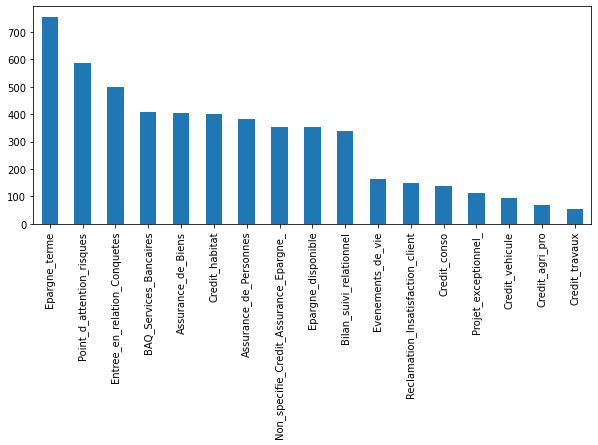

In [74]:
my_tags = ['Assurance_de_Biens', 'Assurance_de_Personnes',
       'BAQ_Services_Bancaires', 'Bilan_suivi_relationnel',
       'Credit_agri_pro', 'Credit_conso', 'Credit_habitat',
       'Credit_travaux', 'Credit_vehicule',
       'Entree_en_relation_Conquetes', 'Epargne_disponible',
       'Epargne_terme', 'Evenements_de_vie',
       'Non_specifie_Credit_Assurance_Epargne_',
       'Point_d_attention_risques', 'Projet_exceptionnel_',
       'Reclamation_Insatisfaction_client']
plt.figure(figsize=(10,4))
df.category.value_counts().plot(kind='bar');

In [75]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('french'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
    
df['text'] = df['text'].apply(clean_text)

In [76]:
X = df.text
y = df.category
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [77]:
df

,category,text,content,category_id
0,Assurance_de_Biens,entretien monsieur proposition dassurance auto...,assurance auto,0
1,Assurance_de_Biens,entretien monsieur proposition dassurance auto...,assurance auto,0
2,Assurance_de_Biens,cliente cliente reu 8 octobre rengociation crd...,assurance automobile,0
3,Assurance_de_Biens,rendezvous connaissance marie 3 enfants 4 peti...,IARD,0
4,Assurance_de_Biens,cliente tudiante bts fin tude juin 2020 a reco...,NH,0
...,...,...,...,...
5260,Reclamation_Insatisfaction_client,mcontente suite fraude cb prise charge poste p...,mécontente,16
5261,Reclamation_Insatisfaction_client,bilan assurance fait jour madame assure chez g...,nous sommes 2x plus cher,16
5262,Reclamation_Insatisfaction_client,cliente dtient compte courant livret a lep ass...,n'est pas intéressée par les produits PACIFICA,16
5263,Reclamation_Insatisfaction_client,mr mme compte egalement a caisse dep sen serve...,enfants,16


# TEST NAIVE BAYES MULTINOMIAL

In [78]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)


from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.2518987341772152
                                        precision    recall  f1-score   support

                    Assurance_de_Biens       0.26      0.10      0.15       137
                Assurance_de_Personnes       0.25      0.06      0.09       127
                BAQ_Services_Bancaires       0.38      0.30      0.34       119
               Bilan_suivi_relationnel       0.00      0.00      0.00       102
                       Credit_agri_pro       0.00      0.00      0.00        23
                          Credit_conso       0.00      0.00      0.00        39
                        Credit_habitat       0.39      0.28      0.33       109
                        Credit_travaux       0.00      0.00      0.00        12
                       Credit_vehicule       0.00      0.00      0.00        29
          Entree_en_relation_Conquetes       0.23      0.23      0.23       137
                    Epargne_disponible       0.23      0.05      0.09        95
           

/Users/manon/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# TEST LSVM

In [79]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)



y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.2379746835443038
                                        precision    recall  f1-score   support

                    Assurance_de_Biens       0.23      0.18      0.20       137
                Assurance_de_Personnes       0.19      0.13      0.15       127
                BAQ_Services_Bancaires       0.28      0.29      0.29       119
               Bilan_suivi_relationnel       0.17      0.13      0.15       102
                       Credit_agri_pro       0.29      0.35      0.31        23
                          Credit_conso       0.15      0.13      0.14        39
                        Credit_habitat       0.29      0.37      0.32       109
                        Credit_travaux       0.17      0.17      0.17        12
                       Credit_vehicule       0.13      0.14      0.13        29
          Entree_en_relation_Conquetes       0.17      0.23      0.19       137
                    Epargne_disponible       0.17      0.23      0.20        95
           

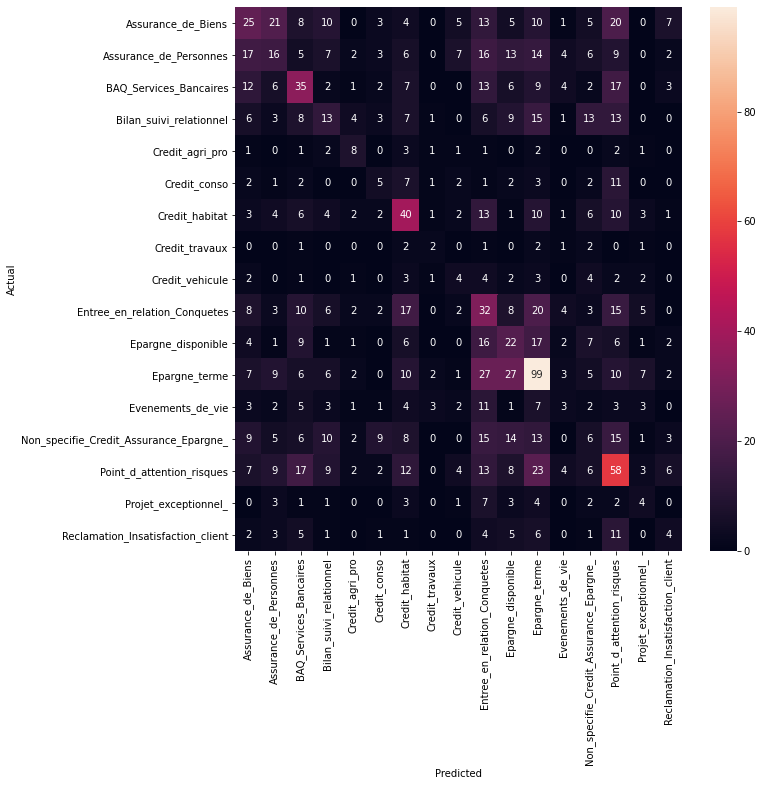

In [80]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.category.values, yticklabels=category_id_df.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# TEST LOG REG

In [81]:

from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)



y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.2189873417721519
                                        precision    recall  f1-score   support

                    Assurance_de_Biens       0.27      0.25      0.26       137
                Assurance_de_Personnes       0.16      0.13      0.15       127
                BAQ_Services_Bancaires       0.26      0.31      0.28       119
               Bilan_suivi_relationnel       0.14      0.13      0.14       102
                       Credit_agri_pro       0.14      0.09      0.11        23
                          Credit_conso       0.12      0.05      0.07        39
                        Credit_habitat       0.29      0.33      0.31       109
                        Credit_travaux       0.07      0.08      0.07        12
                       Credit_vehicule       0.14      0.17      0.16        29
          Entree_en_relation_Conquetes       0.18      0.20      0.19       137
                    Epargne_disponible       0.16      0.21      0.18        95
           

/Users/manon/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


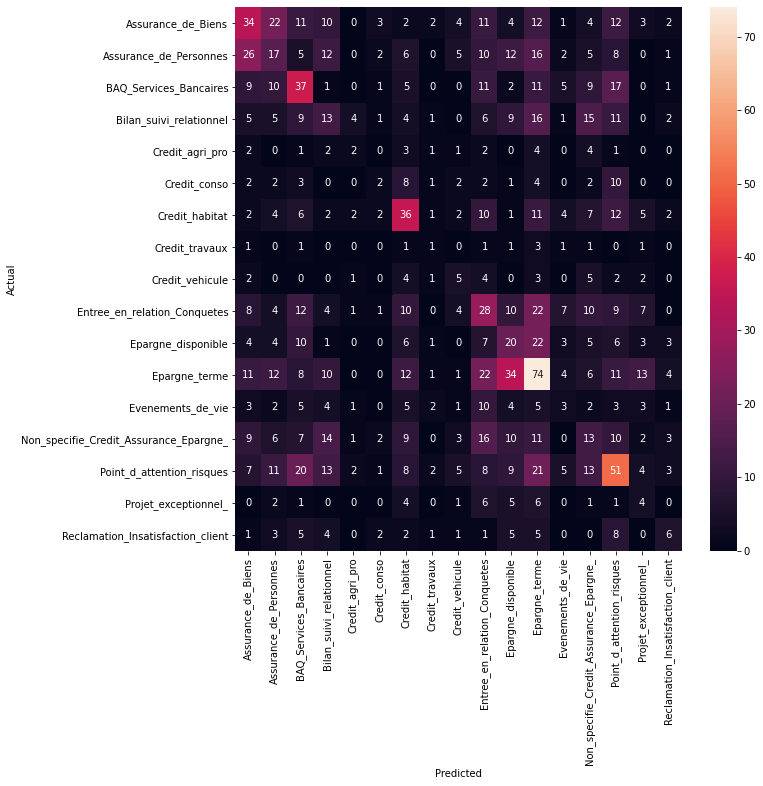

In [82]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.category.values, yticklabels=category_id_df.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()